**To be able to run this notebook you need to install the modified PennyLane version that contains the `qml.kernels` module via**
```
pip install git+https://www.github.com/johannesjmeyer/pennylane@kernel_module --upgrade
```

### Initialization and circuit definitions

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import datasets

np.random.seed(42)

## Define circuit

In [2]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding Ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])
        
    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

@qml.template
def ansatz(x, params, wires):
    """The embedding Ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

In [3]:
def random_params(num_wires, num_layers):
    return np.random.uniform(0, 2*np.pi, (num_layers, 2, num_wires))

def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

def accuracy_predict(Y_predict, Y_target):
    return 1 - np.count_nonzero(Y_predict - Y_target) / len(Y_target)

## Define circuit hyperparameters

In [4]:
features = 2
width = 3
depth = 3

## Intialize device and hyperparameters

In [5]:
# init device
dev = qml.device("default.qubit", wires=width)
wires = list(range(width))

# init the embedding kernel
k = qml.kernels.EmbeddingKernel(lambda x, params: ansatz(x, params, wires), dev)

## Define dataset

Two pairs of concenctric circles centered at +/- 1 and small radius .4, big radius .8.
Classes are inverted right and left

In [6]:
def datagen (n_train, n_test):
    # generate data in two circles
    # the radii are chosen so that data is balanced
    n_part = int(n_train/2)
    n_test = int(n_test/2)
    i = 0
    X = []
    X_ = []
    y = []
    y_ = []
    while (i<n_part):
        x1 = np.random.uniform(-.707,.707) # 0.707... = 0.5*\sqrt(2)
        x2 = np.random.uniform(-.707,.707)
        if((x1)*(x1) + x2*x2 < .5):
            i+=1
            X.append([1+x1,x2])
            if(x1*x1 + x2*x2 < .25):
                y.append(1)
            else:
                y.append(-1)
    
    i=0
    while(i<n_part):
        x1 = np.random.uniform(-.707,.707)
        x2 = np.random.uniform(-.707,.707)
        if(x1*x1 + x2*x2 <.5):
            i+=1
            X.append([x1-1,x2])
            if(x1*x1 + x2*x2 < .25):
                y.append(-1)
            else:
                y.append(1)
    
    i = 0
    while (i<n_test):
        x1 = np.random.uniform(-.707,.707)
        x2 = np.random.uniform(-.707,.707)
        if(x1*x1 + x2*x2 < .5):
            i+=1
            X_.append([1+x1,x2])
            if(x1*x1 + x2*x2 < .25):
                y_.append(1)
            else:
                y_.append(-1)
    
    i=0
    while(i<n_test):
        x1 = np.random.uniform(-.707,.707)
        x2 = np.random.uniform(-.707,.707)
        if(x1*x1 + x2*x2 <.5):
            i+=1
            X_.append([x1-1,x2])
            if(x1*x1 + x2*x2 < .25):
                y_.append(-1)
            else:
                y_.append(1)
            
    return X,y, X_,y_

In [7]:
X_train ,y_train, X_test, y_test = datagen(60,60)

In [8]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [9]:
X_train.shape, X_test.shape

((60, 2), (60, 2))

The training data is as follows:


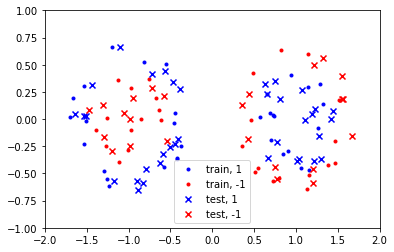

In [10]:
# plot for visual inspection
print("The training data is as follows:")
plt.scatter(X_train[np.where(y_train == 1)[0],0], X_train[np.where(y_train == 1)[0],1], color="b", marker=".", label="train, 1")
plt.scatter(X_train[np.where(y_train == -1)[0],0], X_train[np.where(y_train == -1)[0],1], color="r", marker=".", label="train, -1")
#print("The test data is as follows:")
plt.scatter(X_test[np.where(y_test == 1)[0],0], X_test[np.where(y_test == 1)[0],1], color="b", marker="x", label="test, 1")
plt.scatter(X_test[np.where(y_test == -1)[0],0], X_test[np.where(y_test == -1)[0],1], color="r", marker="x", label="test, -1")
plt.ylim([-1, 1])
plt.xlim([-2, 2])
plt.legend()
plt.show()

# Random Parameters

### Assessment of random initialization

In [11]:
# make various runs with random parameters to see what range the results can be in
acc_log = []
params_log = []
test_predict_log = []
train_predict_log = []
for i in range(1):
    ## choose random params for the kernel
    params = random_params(width, depth)
    #print(params)
    ## fit the SVM on the training data
    svm_untrained_kernel = SVC(kernel=lambda X1, X2: k.kernel_matrix(X1, X2, params)).fit(X_train, y_train)
    ## evaluate on the test set
    test_predict_log.append(svm_untrained_kernel.predict(X_test))
    train_predict_log.append(svm_untrained_kernel.predict(X_train))
    untrained_accuracy_test = accuracy_predict(test_predict_log[-1], y_test)
    untrained_accuracy_train = accuracy_predict(train_predict_log[-1], y_train)
    print("without kernel training accuracy on test", untrained_accuracy_test)
    print("without kernel training accuracy on train", untrained_accuracy_train)
    acc_log.append(untrained_accuracy_test)
    params_log.append(params)
print("going with", acc_log[np.argmin(np.asarray(acc_log))])

without kernel training accuracy on test 0.7
without kernel training accuracy on train 0.65
going with 0.7


In [12]:
params_random = params_log[np.argmin(np.asarray(acc_log))]

In [14]:
startx = -2
stopx = 2
starty = -1
stopy = 1
num = 20

X_dummy = []

incx = (stopx-startx)/num
incy = (stopy-starty)/num

for i in range(num):
    for j in range(num):
        X_dummy.append([startx + i*incx,starty + j*incy])

## Train SVM

In [15]:
y_dummy_random = svm_untrained_kernel.decision_function(X_dummy)

In [17]:
X_dummy = np.asarray(X_dummy)
y_dummy_random = np.asarray(y_dummy_random)

## Save results and create plot

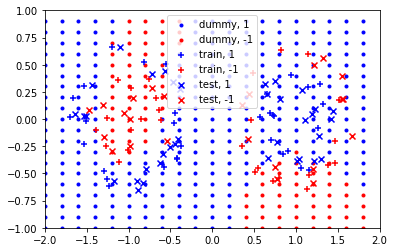

In [19]:
y_dummy_random = np.asarray(y_dummy_random)
y_dummy_random_label = np.sign(y_dummy_random)

plt.scatter(X_dummy[np.where(y_dummy_random_label == 1)[0],0], X_dummy[np.where(y_dummy_random_label == 1)[0],1], color="b", marker=".",label="dummy, 1")
plt.scatter(X_dummy[np.where(y_dummy_random_label == -1)[0],0], X_dummy[np.where(y_dummy_random_label == -1)[0],1], color="r", marker=".",label="dummy, -1")
plt.scatter(X_train[np.where(y_train == 1)[0],0], X_train[np.where(y_train == 1)[0],1], color="b", marker="+", label="train, 1")
plt.scatter(X_train[np.where(y_train == -1)[0],0], X_train[np.where(y_train == -1)[0],1], color="r", marker="+", label="train, -1")
plt.scatter(X_test[np.where(y_test == 1)[0],0], X_test[np.where(y_test == 1)[0],1], color="b", marker="x", label="test, 1")
plt.scatter(X_test[np.where(y_test == -1)[0],0], X_test[np.where(y_test == -1)[0],1], color="r", marker="x", label="test, -1")
plt.ylim([-1, 1])
plt.xlim([-2, 2])
plt.legend()


In [23]:
filename = "dataset_symmetricdonuts_randomtest_depth_3_width_3.npy"

In [26]:
y_test = np.asarray(y_test)
with open(filename, 'wb') as f:
    np.save(f, X_dummy)
    np.save(f, y_dummy_random_label)
    np.save(f, y_dummy)
    np.save(f, X_train)
    np.save(f, y_train)
    np.save(f, X_test)
    np.save(f, y_test)

# Trained Parameters

### Gradient Ascent Alignment

In [ ]:
# evaluate the performance with trained parameters for the kernel
## train the kernel
opt = qml.GradientDescentOptimizer(1)
for i in range(1000):
    subset = np.random.choice(list(range(len(X_train))), 4)
    params = opt.step(lambda _params: -k.target_alignment(X_train[subset], y_train[subset], _params), params)
    
    if (i+1) % 50 == 0:
        print("Step {} - Alignment on train = {:.3f}".format(i+1, k.target_alignment(X_train, y_train, params)))
# ### Train SVM
# evaluate the performance with trained parameters for the kernel
## train the kernel
#opt = qml.GradientDescentOptimizer(1)
#for i in range(1000):
#    subset = np.random.choice(list(range(len(X_train))), 4)
#    params = opt.step(lambda _params: -k.target_alignment(X_train[subset], y_train[subset], _params), params)
    
#    if (i+1) % 50 == 0:
#        print("Step {} - Alignment on train = {:.3f}".format(i+1, k.target_alignment(X_train, y_train, params)))
# ### Train SVM

In [ ]:
opt = qml.GradientDescentOptimizer(1)
for i in range(1000):

    subset = np.random.choice(list(range(len(X_train))), 4)
    params = opt.step(lambda _params: -k.target_alignment(X_train[subset], y_train[subset], _params), params)
    
    if (i+1) % 50 == 0:
        print("Step {} - Alignment on train = {:.3f}".format(i+1, k.target_alignment(X_train, y_train, params)))

In [15]:
## fit the SVM on the train set
svm_trained_kernel = SVC(kernel=lambda X1, X2: k.kernel_matrix(X1, X2, params)).fit(X_train, y_train)
p_train = svm_trained_kernel.predict(X_train)
p_test = svm_trained_kernel.predict(X_test)

## evaluate the accuracy on the test set
trained_accuracy = accuracy(svm_trained_kernel, X_train, y_train)
test_accuracy = accuracy(svm_trained_kernel, X_test, y_test)
print("with kernel training accuracy on train", trained_accuracy)
print("with kernel training accuracy on test", test_accuracy)

with kernel training accuracy on train 0.65
with kernel training accuracy on test 0.7


### Plot results

In [21]:
startx = -2
stopx = 2
starty = -1
stopy = 1
num = 20

X_dummy = []

incx = (stopx-startx)/num
incy = (stopy-starty)/num

for i in range(num):
    for j in range(num):
        X_dummy.append([startx + i*incx,starty + j*incy])

In [22]:
y_dummy = svm_trained_kernel.decision_function(X_dummy)

KeyboardInterrupt: 

In [18]:
X_dummy = np.asarray(X_dummy)
y_dummy = np.asarray(y_dummy)

NameError: name 'y_dummy' is not defined

In [43]:
#y_dummy_label = np.sign(y_dummy)
print(X_dummy)
plt.scatter(X_dummy[np.where(y_dummy_label == 1)[0],0], X_dummy[np.where(y_dummy_label == 1)[0],1], color="b", marker=".",label="dummy, 1")
plt.scatter(X_dummy[np.where(y_dummy_label == -1)[0],0], X_dummy[np.where(y_dummy_label == -1)[0],1], color="r", marker=".",label="dummy, -1")
plt.scatter(X_train[np.where(y_train == 1)[0],0], X_train[np.where(y_train == 1)[0],1], color="b", marker="+", label="train, 1")
plt.scatter(X_train[np.where(y_train == -1)[0],0], X_train[np.where(y_train == -1)[0],1], color="r", marker="+", label="train, -1")
plt.scatter(X_test[np.where(y_test == 1)[0],0], X_test[np.where(y_test == 1)[0],1], color="b", marker="x", label="test, 1")
plt.scatter(X_test[np.where(y_test == -1)[0],0], X_test[np.where(y_test == -1)[0],1], color="r", marker="x", label="test, -1")
plt.ylim([-1, 1])
plt.xlim([-2, 2])
plt.legend()
plt.scatter(X_dummy[:,0], X_dummy[:,1],marker='s', s=140, c= y_dummy, alpha=0.9)
plt.colorbar()

[[-2.0, -1.0], [-2.0, -0.9], [-2.0, -0.8], [-2.0, -0.7], [-2.0, -0.6], [-2.0, -0.5], [-2.0, -0.3999999999999999], [-2.0, -0.29999999999999993], [-2.0, -0.19999999999999996], [-2.0, -0.09999999999999998], [-2.0, 0.0], [-2.0, 0.10000000000000009], [-2.0, 0.20000000000000018], [-2.0, 0.30000000000000004], [-2.0, 0.40000000000000013], [-2.0, 0.5], [-2.0, 0.6000000000000001], [-2.0, 0.7000000000000002], [-2.0, 0.8], [-2.0, 0.9000000000000001], [-1.8, -1.0], [-1.8, -0.9], [-1.8, -0.8], [-1.8, -0.7], [-1.8, -0.6], [-1.8, -0.5], [-1.8, -0.3999999999999999], [-1.8, -0.29999999999999993], [-1.8, -0.19999999999999996], [-1.8, -0.09999999999999998], [-1.8, 0.0], [-1.8, 0.10000000000000009], [-1.8, 0.20000000000000018], [-1.8, 0.30000000000000004], [-1.8, 0.40000000000000013], [-1.8, 0.5], [-1.8, 0.6000000000000001], [-1.8, 0.7000000000000002], [-1.8, 0.8], [-1.8, 0.9000000000000001], [-1.6, -1.0], [-1.6, -0.9], [-1.6, -0.8], [-1.6, -0.7], [-1.6, -0.6], [-1.6, -0.5], [-1.6, -0.3999999999999999], [-

NameError: name 'y_dummy_label' is not defined

In [23]:
y_dummy_random = svm_untrained_kernel.decision_function(X_dummy)

In [45]:
y_dummy_random = np.asarray(y_dummy_random)
y_dummy_random_label = np.sign(y_dummy_random)
#print(X_dummy,'x dummy')
#print(X_dummy[np.where(y_dummy_random_label == 1)[0],0])
plt.scatter(X_dummy[np.where(y_dummy_label == 1)[0],0], X_dummy[np.where(y_dummy_label == 1)[0],1], color="b", marker=".",label="dummy, 1")
plt.scatter(X_dummy[np.where(y_dummy_random_label == -1)[0],0], X_dummy[np.where(y_dummy_random_label == -1)[0],1], color="r", marker=".",label="dummy, -1")
plt.scatter(X_train[np.where(y_train == 1)[0],0], X_train[np.where(y_train == 1)[0],1], color="b", marker="+", label="train, 1")
plt.scatter(X_train[np.where(y_train == -1)[0],0], X_train[np.where(y_train == -1)[0],1], color="r", marker="+", label="train, -1")
plt.scatter(X_test[np.where(y_test == 1)[0],0], X_test[np.where(y_test == 1)[0],1], color="b", marker="x", label="test, 1")
plt.scatter(X_test[np.where(y_test == -1)[0],0], X_test[np.where(y_test == -1)[0],1], color="r", marker="x", label="test, -1")
plt.ylim([-1, 1])
plt.xlim([-2, 2])
plt.legend()

NameError: name 'y_dummy_label' is not defined

In [ ]:
plt.scatter(X_dummy[:,0], X_dummy[:,1],marker='s', s=140, c= y_dummy_random, alpha=0.9)
plt.colorbar()

In [ ]:
filename = "dataset_symmetricdonuts_randomtest_depth_3_width_3.npy"

In [ ]:
with open(filename, 'wb') as f:
    np.save(f, X_dummy)
    np.save(f, y_dummy_random_label)
    np.save(f, y_dummy)
    np.save(f, X_train)
    np.save(f, y_train)
    np.save(f, X_test)
    np.save(f, y_test)

with open(filename, 'rb') as f:
    X_dummy_c = np.load(f)
    y_dummy_label_c = np.load(f)
    y_dummy_c = np.load(f)
    X_train_c = np.load(f)
    y_train_c = np.load(f)
    X_test_c = np.load(f)
    y_test_c = np.load(f)

plt.scatter(X_dummy_c[np.where(y_dummy_label_c == 1)[0],0], X_dummy_c[np.where(y_dummy_label_c == 1)[0],1], color="b", marker=".",label="dummy, 1")
plt.scatter(X_dummy_c[np.where(y_dummy_label_c == -1)[0],0], X_dummy_c[np.where(y_dummy_label_c == -1)[0],1], color="r", marker=".",label="dummy, -1")
plt.scatter(X_train_c[np.where(y_train_c == 1)[0],0], X_train_c[np.where(y_train_c == 1)[0],1], color="b", marker="+", label="train, 1")
plt.scatter(X_train_c[np.where(y_train_c == -1)[0],0], X_train_c[np.where(y_train_c == -1)[0],1], color="r", marker="+", label="train, -1")
plt.scatter(X_test_c[np.where(y_test_c == 1)[0],0], X_test_c[np.where(y_test_c == 1)[0],1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_c[np.where(y_test_c == -1)[0],0], X_test_c[np.where(y_test_c == -1)[0],1], color="r", marker="x", label="test, -1")
plt.ylim([-1, 1])
plt.xlim([-2, 2])
plt.legend()

filename = "parameters_symmetricdonuts.npy"

with open(filename, 'wb') as f:
    np.save(f, params)
    np.save(f, params_random)

with open(filename, 'rb') as f:
    params_c = np.load(f)
    params_random_c = np.load(f)

coef = svm_trained_kernel.dual_coef_

intercept = svm_trained_kernel.intercept_

support = svm_trained_kernel.support_

print(len(coef[0]), len(support))

coef

intercept

(width,depth)

(3,3): acc_train 0.65 to 0.85, acc_test 0.583 to 0.77, alignment 0.02 to 0.06

(3,4): acc_train 0.7 to 0.93, acc_test 0.583 to 0.87, alignment 0.037 to 0.088